In [142]:
%load_ext autoreload
%autoreload 2
from logistic import LinearModel, LogisticRegression, GradientDescentOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Abstract
In this blog post we will be implementing our own logistic regression model from scratch. Here you will be able to see the experiments that we have done with the model. The experiments highlight 4 topics: Vanilla Gradient Descent, Gradient Descent with Momentum, Overfitting, and Empirical Data. To see the implementation of our Logistic Regression model you can view this link https://github.com/RobsanD23/github_RobsanD23/blob/main/posts/logisitc_regression/logistic.py.

# Experiments
In the following cell, we generate data for a classification problem. This function takes 3 parameters: n_points, noise, and p_dims. n_points simply tell the funtion how many data points to make, noise determine how difficult the classification problem is, and p_dims is the number of features for each data point.

In [160]:
import torch

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.5)

In [144]:
y.shape

torch.Size([300])

In [145]:
# This is a simple example of how to use the LogisticRegression class.
# Main purpose is to make sure that there are no syntax errors in our implementation.
LR = LogisticRegression() 
LR.score(X)
opt = GradientDescentOptimizer(LR)
for _ in range(100): 
    opt.step(X, y, alpha = 0.1, beta = 0.9)
opt.model.w

tensor([ 2.6817,  3.1163, -2.9485])

## Vanilla Gradient Descent 
In this section, we are going to set beta to 0 so that we can visualize "regular" gradient descent (i.e., without momentum). Below we will perform a step for 3000 iterations and at each iteration we with compute the loss and store it in a list. 

In [146]:
LR2 = LogisticRegression()
LR2.score(X)
opt2 = GradientDescentOptimizer(LR2)
loss_vec = []
for _ in range(3000):
    loss =LR2.loss(X, y)
    loss_vec.append(loss) # keep track of the loss over time. 
    opt2.step(X, y, alpha = 0.1, beta = 0)
    

Now its time to plot the loss after each step of the gradient descent optimizer. As you can see from the graph below, the loss is decreasing at each step. This is a good sign that our gradient descent optimizer is working correctly.

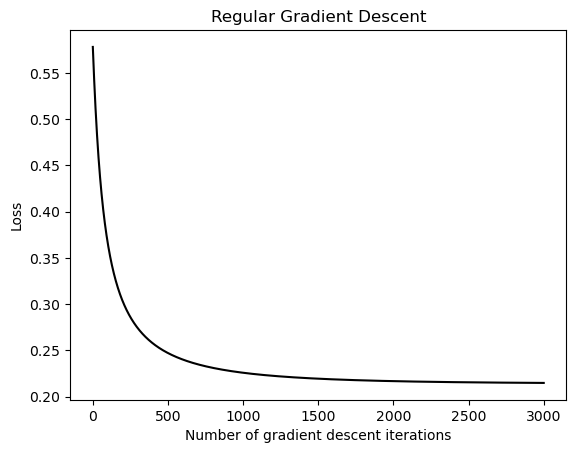

In [147]:
import matplotlib.pyplot as plt

plt.plot(torch.arange(1, len(loss_vec)+1), loss_vec, color = "black")

labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss", title = "Regular Gradient Descent")

## Benefits of Momentum 
Now we are going to set beta to 0.9 so that we can take advantage of our implementation of gradient descent with momentum algorithm. To see the effect of momentum we will keep every other argument the same as before and compare the results.

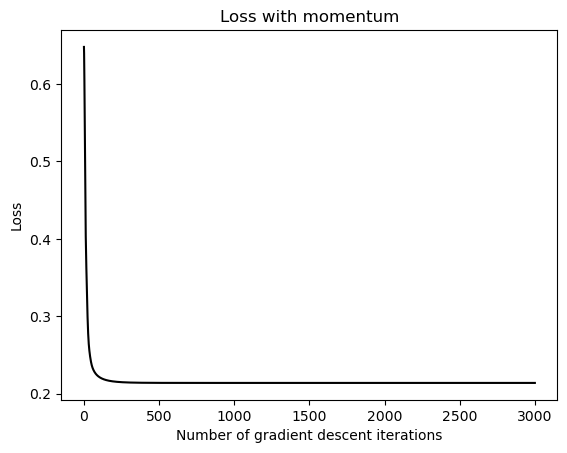

In [148]:
LR3 = LogisticRegression()
LR3.score(X)
opt3 = GradientDescentOptimizer(LR3)
loss_v = []
for _ in range(3000):
    loss =LR3.loss(X, y)
    loss_v.append(loss) # keep track of the loss over time. 
    opt3.step(X, y, alpha = 0.1, beta = 0.9)

plt.plot(torch.arange(1, len(loss_v)+1), loss_v, color = "black")

labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss",title = "Loss with momentum")

As you can see from the 2 graphs above, gradient descent with momentum is able to achieve optimal loss with fewer iterations than regular gradient descent. For regular gradient descent, it took about 3000 iterations to reach optimal loss, while gradient descent with momentum was able to do it in abut 250 iterations. This is a significant improvement and shows the power of using momentum in gradient descent optimization.

## Overfitting

Now we are going to show the effect of overfitting our model on training data. To start we are going to create a training set and a test set shown in the cell below. Note that the number of features is larger than the number of data points. 

In [149]:
X_train, y_train = classification_data(50, 0.8, 100)
X_test, y_test = classification_data(50, 0.8, 100)


Now we are going to train our model on the training set until it achieves 100% accuracy.

In [150]:
LR4 = LogisticRegression()
LR4.score(X_train)
opt4 = GradientDescentOptimizer(LR4)
for _ in range(100):
    opt4.step(X_train, y_train, alpha = 0.1, beta = 0.9)

In the cell below, we calculate the accuracy of our model on the training set and see that it is 100%. In the following cell, we will calculate the accuracy of our model on the test set and see that it is only 78%. This is a significant drop in accuracy and shows that our model is overfitting the training data. This is becuase our model is overfitted on the training data and is not able to generalize to the test data.

In [151]:
(LR4.predict(X_train) == y_train).float().mean()


tensor(1.)

In [152]:
(LR4.predict(X_test) == y_test ).float().mean()

tensor(0.8400)

## Performance on Empirical Data
In this section, we are going to train and test our model on a real dataset. The imported dataset contains various features and based on these features we are going to decide whether a person dropped out of school of if they graduated. Below we import the dataset and change the data in to torch tensors. 

In [157]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
  
# data (as pandas dataframes) 
X = predict_students_dropout_and_academic_success.data.features
X = torch.tensor(X.values, dtype = torch.float32) 
y = predict_students_dropout_and_academic_success.data.targets 
y['num'] = (y['Target'] == "Graduate").astype(float)
y = torch.tensor(y['num'], dtype=torch.float32)

  
# metadata 
# print(predict_students_dropout_and_academic_success.metadata) 
  
# variable information 
# print(predict_students_dropout_and_academic_success.variables)


C:\Users\robsa\AppData\Local\Temp\ipykernel_48004\847060615.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['num'] = (y['Target'] == "Graduate").astype(float)


Here we split the data in to a training set and a test set. We will use the training set to train our model and the test set to evaluate the performance of our model.

In [154]:
from sklearn.model_selection import train_test_split

# Custom split ratios
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

# First split: train and temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_ratio), random_state=42)

# Second split: validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(test_ratio / (test_ratio + validation_ratio)), random_state=42)

Now we will train our model on the training set and see what the accuracy is on it. 

In [166]:
LR5 = LogisticRegression()
LR5.score(X_train)
opt5 = GradientDescentOptimizer(LR5)
for _ in range(100000): 
    opt5.step(X_train, y_train, alpha = 0.1, beta = 0.99)
(LR5.predict(X_train) == y_train).float().mean()

tensor(0.8255)

Now on the test set we see that the accuracy is about 82%.

In [167]:
(LR5.predict(X_test) == y_test).float().mean()


tensor(0.8237)

# Conclusion
In this blog post we have implemented our own logistic regression model from scratch. We have shown that gradient descent with momentum achieves a lower loss with fewer iterations when compared to vanilla gradient descent. Also we have show that overfitting a model can lead to increased accuracy on the training data while also decreasing accuracy on testing data. Finally, we have trained and tested our model on a real dataset and achieved an accuracy of 82%.